## Saâd AZIZ ALAOUI & Simoné IANNELLI
## MATHSAPPS BAYES MICE WINBUGS VOL 1

## Import des Librairies et Data Prep

In [1]:
import numpy as np
from numpy.random import normal
from scipy.stats import weibull_min, logistic, norm, gamma, expon, truncweibull_min
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Vecteur des failure times (les individus censurés ont un nan)
t =np.array([12,17,21, 25, 11,  26,  27,  30, 13, 12,  21,20,  23,  25,  23,  29, 35, np.nan, 31, 36,
     32, 27,  23, 12, 18, np.nan, np.nan,  38, 29, 30, np.nan, 32, np.nan, np.nan, np.nan, np.nan, 25,  30, 37, 27,
     22, 26, np.nan, 28, 19,  15,  12,  35, 35, 10,  22, 18, np.nan,  12, np.nan, np.nan, 31,  24, 37, 29,
     27, 18,  22, 13, 18,  29,  28, np.nan, 16, 22,  26, 19, np.nan, np.nan,  17,  28, 26,  12, 17, 26])

# les individus censurés ont une valeur différente de zéro (leur temps de censure en semaines)
tcensor =np.array([0, 0,  0, 0, 0,  0,  0,  0, 0, 0,  0, 0,  0,  0,  0,  0, 0, 40, 0, 0,
     0, 0,  0, 0, 0, 40, 40,  0, 0, 0, 40, 0, 40, 40, 40, 40, 0,  0, 0, 0,
     0, 0, 10, 0, 0,  0,  0,  0, 0, 0,  0, 0, 24,  0, 40, 40, 0,  0, 0, 0,
     0, 0,  0, 0, 0,  0,  0, 20, 0, 0,  0, 0, 29, 10,  0,  0, 0,  0, 0, 0])

# Vecteur pour construire l'indicatrice
is_censored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 
0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 
0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

# temps des individus non censurés
t_uncensored =np.array([12, 17, 21, 25, 11, 26, 27, 30, 13, 12, 21, 20, 23, 25, 23, 
29, 35, 31, 36, 32, 27, 23, 12, 18, 38, 29, 30, 32, 25, 30, 37, 
27, 22, 26, 28, 19, 15, 12, 35, 35, 10, 22, 18, 12, 31, 24, 37, 
29, 27, 18, 22, 13, 18, 29, 28, 16, 22, 26, 19, 17, 28, 26, 12, 
17, 26])

# groupe d'appartenance, utile pour les beta_j
group_mice = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

len_uncens = len(t_uncensored)
len_cens = 80 - len_uncens
len_group = 4


In [3]:
# Guess initiaux pour les paramètres
init_r = 1 
init_beta1 = -1
init_beta2 = -1
init_beta3 = -1
init_beta4 = -1
init_vehcontrol = 0
init_testsub = 0
init_poscontrol = 0

## Fonctions auxiliaires pour le calcul des distributions

In [4]:
def dens_weib(k,lamb,data): 
    """
    k, lamb: paramètres de la loi 
    data: array numpy des t_i
    """

    dens = (k-1) * np.log(np.array(data)/lamb) - ((np.array(data)/lamb)**k) + np.log(k/lamb)

    return dens

def survie_weib(k,lamb,data): 
    """
    k, lamb: paramètres de la loi 
    data: array numpy des t_i
    """
    dens = -((np.array(data)/lamb)**k)

    return dens

## Algorithme MCMC GIBBS

In [20]:
def mice(nchain,init_r,init_beta1,init_beta2,init_beta3,init_beta4,init_vehcontrol,init_testsub,init_poscontrol,prop_sd,t,tcen) :
    """
    nchain: taille de la chaine
    init_r, init_beta1,init_beta2,init_beta3,init_beta4,init_vehcontrol,init_testsub,init_poscontrol: valeur initiale des paramètres
    prop_sd: variance du noyau de proposition (un vecteur en pratique avec une valeur pour chaque paramètre)
    t: vecteur des temps de tous les individus (en pratique c'est t)
    tcen: vecteur des individus censurés (en pratique c'est tcensor)
    """

    r = init_r
    beta1 = init_beta1
    beta2 = init_beta2
    beta3 = init_beta3
    beta4 = init_beta4
    veh_control = init_vehcontrol
    testsub = init_testsub
    poscontrol = init_poscontrol
    
    # medianes formules déterministes, initialisation 
    median1 = np.exp(-beta1)*(np.log(2))**(1/r)
    median2 = np.exp(-beta2)*(np.log(2))**(1/r)
    median3 = np.exp(-beta3)*(np.log(2))**(1/r)
    median4 = np.exp(-beta4)*(np.log(2))**(1/r)
    
    # L'état actuel de la chaine est représenté par un vecteur 
    # au total on stocke une matrice, chaque colonne représente un état à un step de temps t
    chain = np.zeros((nchain+1, 12))
    acc_rate = np.zeros(5)
    chain[0,0] = init_r
    chain[0,1] = init_beta1
    chain[0,2] = init_beta2
    chain[0,3] = init_beta3
    chain[0,4] = init_beta4
    chain[0,5] = init_vehcontrol
    chain[0,6] = init_testsub
    chain[0,7] = init_poscontrol
    chain[0,8] = median1
    chain[0,9] = median2
    chain[0,10] = median3
    chain[0,11] = median4

    # on prépare chaque groupe, temps et indicatrices
    t_1 = t[:20] 
    tcen_1 = tcen[:20]
    is_censored_1 = is_censored[:20]
    # temps des censurés et non censurés
    uncensored_array_1 = [t_1[i] for i in range(len(t_1)) if is_censored_1[i] == 0]
    censored_array_1 = [tcen_1[i] for i in range(len(tcen_1)) if is_censored_1[i] == 1]

    # La logique est la même pour tous les groupes
    t_2 = t[20:40]
    tcen_2 = tcen[20:40]
    is_censored_2 = is_censored[20:40]
    uncensored_array_2 = [t_2[i] for i in range(len(t_2)) if is_censored_2[i] == 0]
    censored_array_2 = [tcen_2[i] for i in range(len(tcen_2)) if is_censored_2[i] == 1]

    t_3= t[40:60]
    tcen_3 = tcen[40:60]
    is_censored_3 = is_censored[40:60]
    uncensored_array_3 = [t_3[i] for i in range(len(t_3)) if is_censored_3[i] == 0]
    censored_array_3 = [tcen_3[i] for i in range(len(tcen_3)) if is_censored_3[i] == 1]

    t_4 = t[60:80]
    tcen_4 = tcen[60:80]
    is_censored_4 = is_censored[60:80]
    uncensored_array_4 = [t_4[i] for i in range(len(t_4)) if is_censored_4[i] == 0]
    censored_array_4 = [tcen_4[i] for i in range(len(tcen_4)) if is_censored_4[i] == 1]
    
    for i in range(nchain): 

        # Mise à jour de r pour commencer 
        # proposition venant du kernel 
        prop = normal(loc = r, scale = prop_sd[0])
        
        # d'abord on somme les log vraisemblances sur les individus non-censurés pour chaque groupe 
        # (-10**-3)*prop : log du prior exponentiel sur r
        top = (-10**-3)*prop + sum(dens_weib(prop,np.exp(-beta1),uncensored_array_1)) + sum(dens_weib(prop,np.exp(-beta2),uncensored_array_2)) + sum(dens_weib(prop,np.exp(-beta3),uncensored_array_3)) + sum(dens_weib(prop,np.exp(-beta4),uncensored_array_4))
        # ensuite on somme les log vraisemblances sur les individus censurés pour chaque groupe
        top = top + sum(survie_weib(prop,np.exp(-beta1),censored_array_1)) + sum(survie_weib(prop,np.exp(-beta2),censored_array_2)) + sum(survie_weib(prop,np.exp(-beta3),censored_array_3)) + sum(survie_weib(prop,np.exp(-beta4),censored_array_4))

        # même logique que pour top sauf qu'ici on garde le paramètre actuel 
        bottom = (-10**-3)*r + sum(dens_weib(r,np.exp(-beta1),uncensored_array_1)) + sum(dens_weib(r,np.exp(-beta2),uncensored_array_2)) + sum(dens_weib(r,np.exp(-beta3),uncensored_array_3)) + sum(dens_weib(r,np.exp(-beta4),uncensored_array_4))
        bottom = bottom + sum(survie_weib(r,np.exp(-beta1),censored_array_1)) + sum(survie_weib(r,np.exp(-beta2),censored_array_2)) + sum(survie_weib(r,np.exp(-beta3),censored_array_3)) + sum(survie_weib(r,np.exp(-beta4),censored_array_4))

        # on a travaillé en log vraisemblance sur top et bottom, on doit donc repasser en "échelle scalaire"
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            r = prop
            acc_rate[0] += 1

        # Mise à jour de Beta 1 
        # proposition venant du kernel
        prop = normal(loc = beta1, scale = prop_sd[1])
        
        # Même logique que pour le paramètre de forme r mais ici on fait attention au fait 
        # que chaque beta_j ne fait intervenir que les individus du groupe j
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop),uncensored_array_1)) + sum(survie_weib(r,np.exp(-prop),censored_array_1))
        bottom = - (beta1**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta1),uncensored_array_1)) + sum(survie_weib(r,np.exp(-beta1),censored_array_1))
        acc_prob = np.exp(top - bottom)
        
        if np.random.uniform() < acc_prob:
            beta1 = prop
            acc_rate[1] += 1

        # Mise à jour de Beta 2
        # proposition venant du kernel
        prop = normal(loc = beta2, scale = prop_sd[2])
        # Même logique que pour le paramètre de forme r mais ici on fait attention au fait 
        # que chaque beta_j ne fait intervenir que les individus du groupe j
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop),uncensored_array_2)) + sum(survie_weib(r,np.exp(-prop),censored_array_2))
        bottom = - (beta2**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta2),uncensored_array_2)) + sum(survie_weib(r,np.exp(-beta2),censored_array_2))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta2 = prop
            acc_rate[2] += 1

        # Mise à jour de Beta 3
        # proposition venant du kernel
        prop = normal(loc = beta3, scale = prop_sd[3])
        # Même logique que pour le paramètre de forme r mais ici on fait attention au fait 
        # que chaque beta_j ne fait intervenir que les individus du groupe j
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop),uncensored_array_3)) + sum(survie_weib(r,np.exp(-prop),censored_array_3))
        bottom = - (beta3**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta3),uncensored_array_3)) + sum(survie_weib(r,np.exp(-beta3),censored_array_3))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta3 = prop
            acc_rate[3] += 1

        # Mise à jour de Beta 4
        # proposition venant du kernel
        prop = normal(loc = beta4, scale = prop_sd[4])
        # Même logique que pour le paramètre de forme r mais ici on fait attention au fait 
        # que chaque beta_j ne fait intervenir que les individus du groupe j
        top = - (prop**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-prop),uncensored_array_4)) + sum(survie_weib(r,np.exp(-prop),censored_array_4))
        bottom = - (beta4**2 / (2 * 1e3)) + sum(dens_weib(r,np.exp(-beta4),uncensored_array_4)) + sum(survie_weib(r,np.exp(-beta4),censored_array_4))
        acc_prob = np.exp(top - bottom)

        if np.random.uniform() < acc_prob:
            beta4 = prop
            acc_rate[4] += 1


        # Mise à jours des paramètres déterministes de la chaine
        vehcontrol = beta2 - beta1
        testsub = beta3 -  beta1
        poscontrol = beta4 - beta1
        median1 = np.exp(-beta1)*(np.log(2))**(1/r)
        median2 = np.exp(-beta2)*(np.log(2))**(1/r)
        median3 = np.exp(-beta3)*(np.log(2))**(1/r)
        median4 = np.exp(-beta4)*(np.log(2))**(1/r)
        
        chain[i+1,:] = np.array([r, beta1, beta2, beta3, beta4, median1, median2, median3, median4, vehcontrol, testsub, poscontrol ])

    return(chain,acc_rate)



In [64]:
chain, acc_rate = mice(11000, init_r, init_beta1, init_beta2, init_beta3,init_beta4,init_vehcontrol,init_testsub,
                       init_poscontrol, np.array([0.5,0.2, 0.2, 0.2, 0.2]),t,tcensor)

C:\Users\saada\AppData\Local\Temp\ipykernel_7504\3800645601.py:7: RuntimeWarning: invalid value encountered in log
  dens = (k-1) * np.log(np.array(data)/lamb) - ((np.array(data)/lamb)**k) + np.log(k/lamb)


Text(0.5, 1.0, 'variations de r')

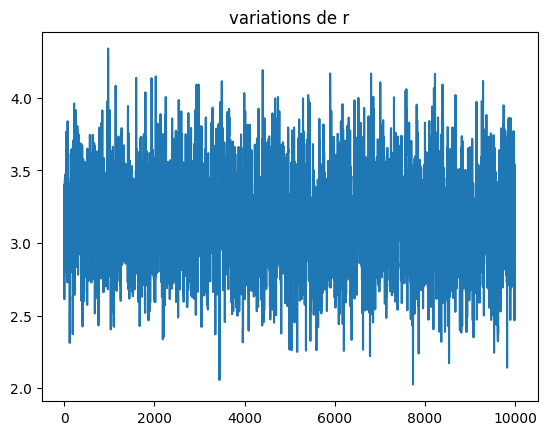

In [65]:
plt.plot(chain[:,0][1000:]) # on retire les 1000 premières itérations (burn-in)
plt.title("variations de r")

In [66]:
print("Le taux d'acceptation de r :" + str(acc_rate[0] / 110) + "%")
mean_r = np.mean(chain[:,0])
print("La moyenne empirique de r :" + str(mean_r))
sd_r = np.std(chain[:,0])
print("L'écart-type empirique de r :" + str(sd_r))

Le taux d'acceptation de r :56.11818181818182%
La moyenne empirique de r :3.1440536962723487
L'écart-type empirique de r :0.35391506205118245


In [75]:
print("Le taux d'acceptation de beta1 :" + str(acc_rate[1] /110) + "%")
mean_beta1 = np.mean(chain[:,1])
print("La moyenne empirique de beta1 :" + str(mean_beta1))
sd_beta1 = np.std(chain[:,1])
print("L'écart-type empirique de beta1 :" + str(sd_beta1))
print("------------------------")
print("Le taux d'acceptation de beta2 :" + str(acc_rate[2] /110) + "%")
mean_beta2 = np.mean(chain[:,2])
print("La moyenne empirique de beta2 :" + str(mean_beta2))
sd_beta2 = np.std(chain[:,2])
print("L'écart-type empirique de beta2 :" + str(sd_beta2))
print("------------------------")
print("Le taux d'acceptation de beta3 :" + str(acc_rate[3] /110) + "%")
mean_beta3 = np.mean(chain[:,3])
print("La moyenne empirique de beta3 :" + str(mean_beta3))
sd_beta3 = np.std(chain[:,3])
print("L'écart-type empirique de beta3 :" + str(sd_beta3))
print("------------------------")
print("Le taux d'acceptation de beta4 :" + str(acc_rate[4] /110) + "%")
mean_beta4 = np.mean(chain[:,4])
print("La moyenne empirique de beta4 :" + str(mean_beta4))
sd_beta4 = np.std(chain[:,4])
print("L'écart-type empirique de beta4 :" + str(sd_beta4))
print("------------------------")
mean_median1 = np.mean(chain[:,5])
print("La moyenne empirique de median1 :" + str(mean_median1))
sd_median1 = np.std(chain[:,5])
print("L'écart-type empirique de median1 :" + str(sd_median1))
print("------------------------")
mean_median2 = np.mean(chain[:,6])
print("La moyenne empirique de median2 :" + str(mean_median2))
sd_median2 = np.std(chain[:,6])
print("L'écart-type empirique de median2 :" + str(sd_median2))
print("------------------------")
mean_median3 = np.mean(chain[:,7])
print("La moyenne empirique de median3 :" + str(mean_median3))
sd_median3 = np.std(chain[:,7])
print("L'écart-type empirique de median3 :" + str(sd_median3))
print("------------------------")
mean_median4 = np.mean(chain[:,8])
print("La moyenne empirique de median4 :" + str(mean_median4))
sd_median4 = np.std(chain[:,8])
print("L'écart-type empirique de median4 :" + str(sd_median4))
print("------------------------")
mean_veh = np.mean(chain[:,9])
print("La moyenne empirique de veh :" + str(mean_veh))
sd_veh = np.std(chain[:,9])
print("L'écart-type empirique de veh :" + str(sd_veh))
print("------------------------")
mean_testsub = np.mean(chain[:,10])
print("La moyenne empirique de testsub :" + str(mean_testsub))
sd_testsub = np.std(chain[:,10])
print("L'écart-type empirique de testsub :" + str(sd_testsub))
print("------------------------")
mean_pos = np.mean(chain[:,11])
print("La moyenne empirique de pos :" + str(mean_pos))
sd_pos = np.std(chain[:,11])
print("L'écart-type empirique de pos :" + str(sd_pos))

Le taux d'acceptation de beta1 :40.736363636363635%
La moyenne empirique de beta1 :-3.3003864428142053
L'écart-type empirique de beta1 :0.09734328077477747
------------------------
Le taux d'acceptation de beta2 :46.345454545454544%
La moyenne empirique de beta2 :-3.671382624730783
L'écart-type empirique de beta2 :0.10716818740810086
------------------------
Le taux d'acceptation de beta3 :43.09090909090909%
La moyenne empirique de beta3 :-3.4071078106980655
L'écart-type empirique de beta3 :0.11302469854004964
------------------------
Le taux d'acceptation de beta4 :41.054545454545455%
La moyenne empirique de beta4 :-3.179840389713269
L'écart-type empirique de beta4 :0.12307783214554574
------------------------
La moyenne empirique de median1 :24.204738094478973
L'écart-type empirique de median1 :2.120862879608007
------------------------
La moyenne empirique de median2 :35.10157331977204
L'écart-type empirique de median2 :3.452955778041584
------------------------
La moyenne empirique

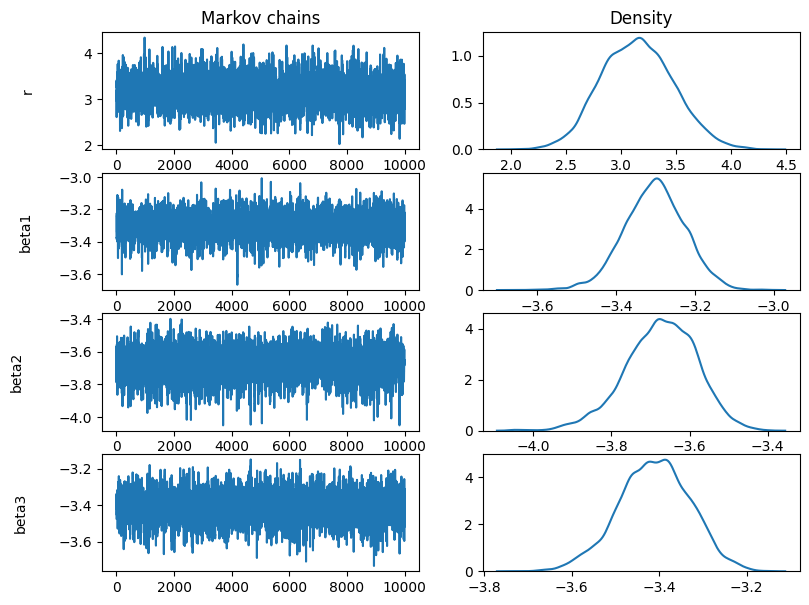

In [72]:
fig, axs = plt.subplots(4, 2, figsize = (9,7))
axs[0, 0].plot(chain[:,0][1000:])
axs[0, 0].set_ylabel('r', labelpad = 35)
axs[0, 0].set_title('Markov chains')
p = sns.kdeplot(ax=axs[0,1], data=chain[:,0][1000:])
p.set_ylabel("")
p.set_title("Density")
axs[1, 0].plot(chain[:,1][1000:])
axs[1, 0].set_ylabel('beta1', labelpad = 19)
sns.kdeplot(ax=axs[1,1], data=chain[:,1][1000:]).set_ylabel("")
axs[2, 0].plot(chain[:,2][1000:])
axs[2, 0].set_ylabel('beta2', labelpad = 25)
sns.kdeplot(ax=axs[2,1], data=chain[:,2][1000:]).set_ylabel("")
axs[3, 0].plot(chain[:,3][1000:])
axs[3, 0].set_ylabel('beta3', labelpad = 22)
sns.kdeplot(ax=axs[3,1], data=chain[:,3][1000:]).set_ylabel("");

## Interprétation des résultats

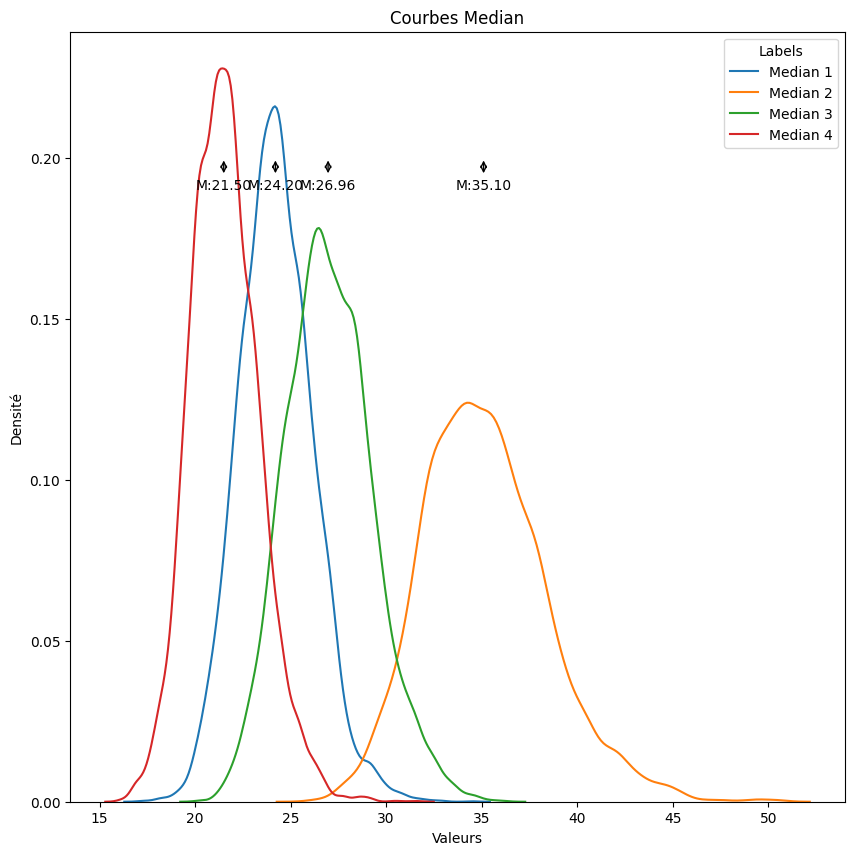

In [90]:
plt.figure(figsize=(10, 10))

sns.kdeplot(data=chain[:,5][1000:], label='Median 1')
sns.kdeplot(data=chain[:,6][1000:], label='Median 2')
sns.kdeplot(data=chain[:,7][1000:], label='Median 3')
sns.kdeplot(data=chain[:,8][1000:], label='Median 4')

mean_values = [mean_median1,mean_median2,mean_median3,mean_median4]
for i, mean_value in enumerate(mean_values, start=5):
    plt.annotate(f'M:{mean_value:.2f}', xy=(mean_value, 0.2), xytext=(mean_value, 0.19),
                 arrowprops=dict(facecolor='black',arrowstyle='<->'),
                 horizontalalignment='center')
    
    
plt.title('Courbes Median')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.legend(title='Labels')
plt.show()